<a href="https://colab.research.google.com/github/surpha/mVQA/blob/main/divide/VQA/Connecting%20Text%20and%20Images/CLIP_Face_discrimination_Indian_Politicians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CLIP to classify photos of Indian Politicians with zero training or finetuning




# Download and Install CLIP Dependencies

> Indented block

In [1]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 12.2
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu1

In [2]:
!pip install gdown

In [3]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 930.5 kB/s eta 0:00:00


In [4]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (127/127), done.
CLIP dir is: /content/CLIP


In [5]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 114MiB/s]


Model dir: /root/.cache/clip


# Obtain the data

We will use a couple of photos, which I manually downloaded from the internet. Photos show three different persons (2 female, 1 male) and there are 4 to 6 images of each person.
Photos are stored in folders named `Donald`, `Elena` and `Svetlana`. However, we will try CLIP with various names to see the effect.

In [9]:
!pip install gdown

import os
import shutil
import gdown
import zipfile

# Define the URL of the zip file on Google Drive
zip_url = 'https://drive.google.com/uc?id=1jEcqqBGm_MLb0UYThScCs3BenWAbFiXN'

# Define the destination folder where you want to download and extract the files
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Download the zip file from Google Drive
zip_file_path = os.path.join(destination_folder, 'file.zip')
gdown.download(zip_url, zip_file_path, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Remove the zip file after extraction
os.remove(zip_file_path)

# List the contents of the extracted folder
extracted_files = os.listdir(destination_folder)
print("Contents of the extracted folder:")
for file in extracted_files:
    print(file)


Downloading...
From: https://drive.google.com/uc?id=1jEcqqBGm_MLb0UYThScCs3BenWAbFiXN
To: /content/file.zip
100%|██████████| 2.74M/2.74M [00:00<00:00, 125MB/s]

Contents of the extracted folder:
.config
clip_people
1LIvczNBudfEEXP5FQSFsE1YFpljujiE0
CLIP
sample_data


# Class labels

We need class definitions for the classification task. Class definitions are provided as text that describe images. For example, `this is an image showing a cat`. Here, `cat` is our class of interest.



In [10]:
import os
# images we want to test are stored in folders with class names
class_names = sorted(os.listdir('./clip_people/'))
class_to_idx = {class_names[i]: i for i in range(len(class_names))}
class_names

['Mamta', 'Narendra', 'Rahul']

In [11]:
class_captions = [f"An image depicting a {x}" for x in class_names]
class_captions

['An image depicting a Mamta',
 'An image depicting a Narendra',
 'An image depicting a Rahul']

Now we tokenize the text and calculate embeddings from tokens

In [12]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([3, 77])
Text features shape: torch.Size([3, 512])


# Prepare images

We will consume images with the help of `ImageFolder` dataset from `PyTorch`.

In [13]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]
    image += image_mean[:, None, None]
    return image

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [15]:
dataset = ImageFolder(root="./clip_people", transform=transform)
data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

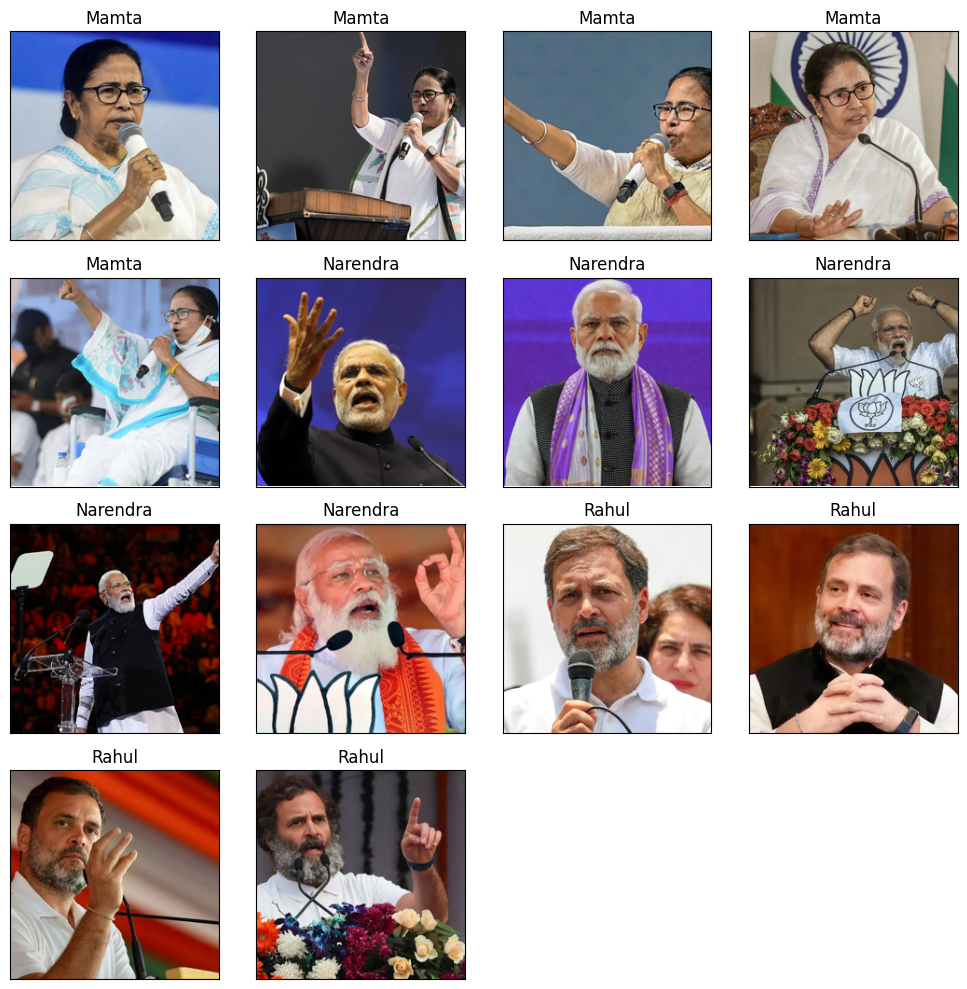

In [16]:
plt.figure(figsize=(10, 10))

# Show all images from the dataset since our dataset is small
for idx, (image, label_idx) in enumerate(dataset):
    cur_class = class_names[label_idx]

    plt.subplot(4, 4, idx+1)
    plt.imshow(denormalize_image(image).permute(1, 2, 0))
    plt.title(f"{cur_class}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Perform classification



In [17]:
# read out all images and true labels
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()


In [18]:
def show_results(image_features, text_features, class_names):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 5])
    # top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(26, 16))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(4, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(4, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, text_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        # plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

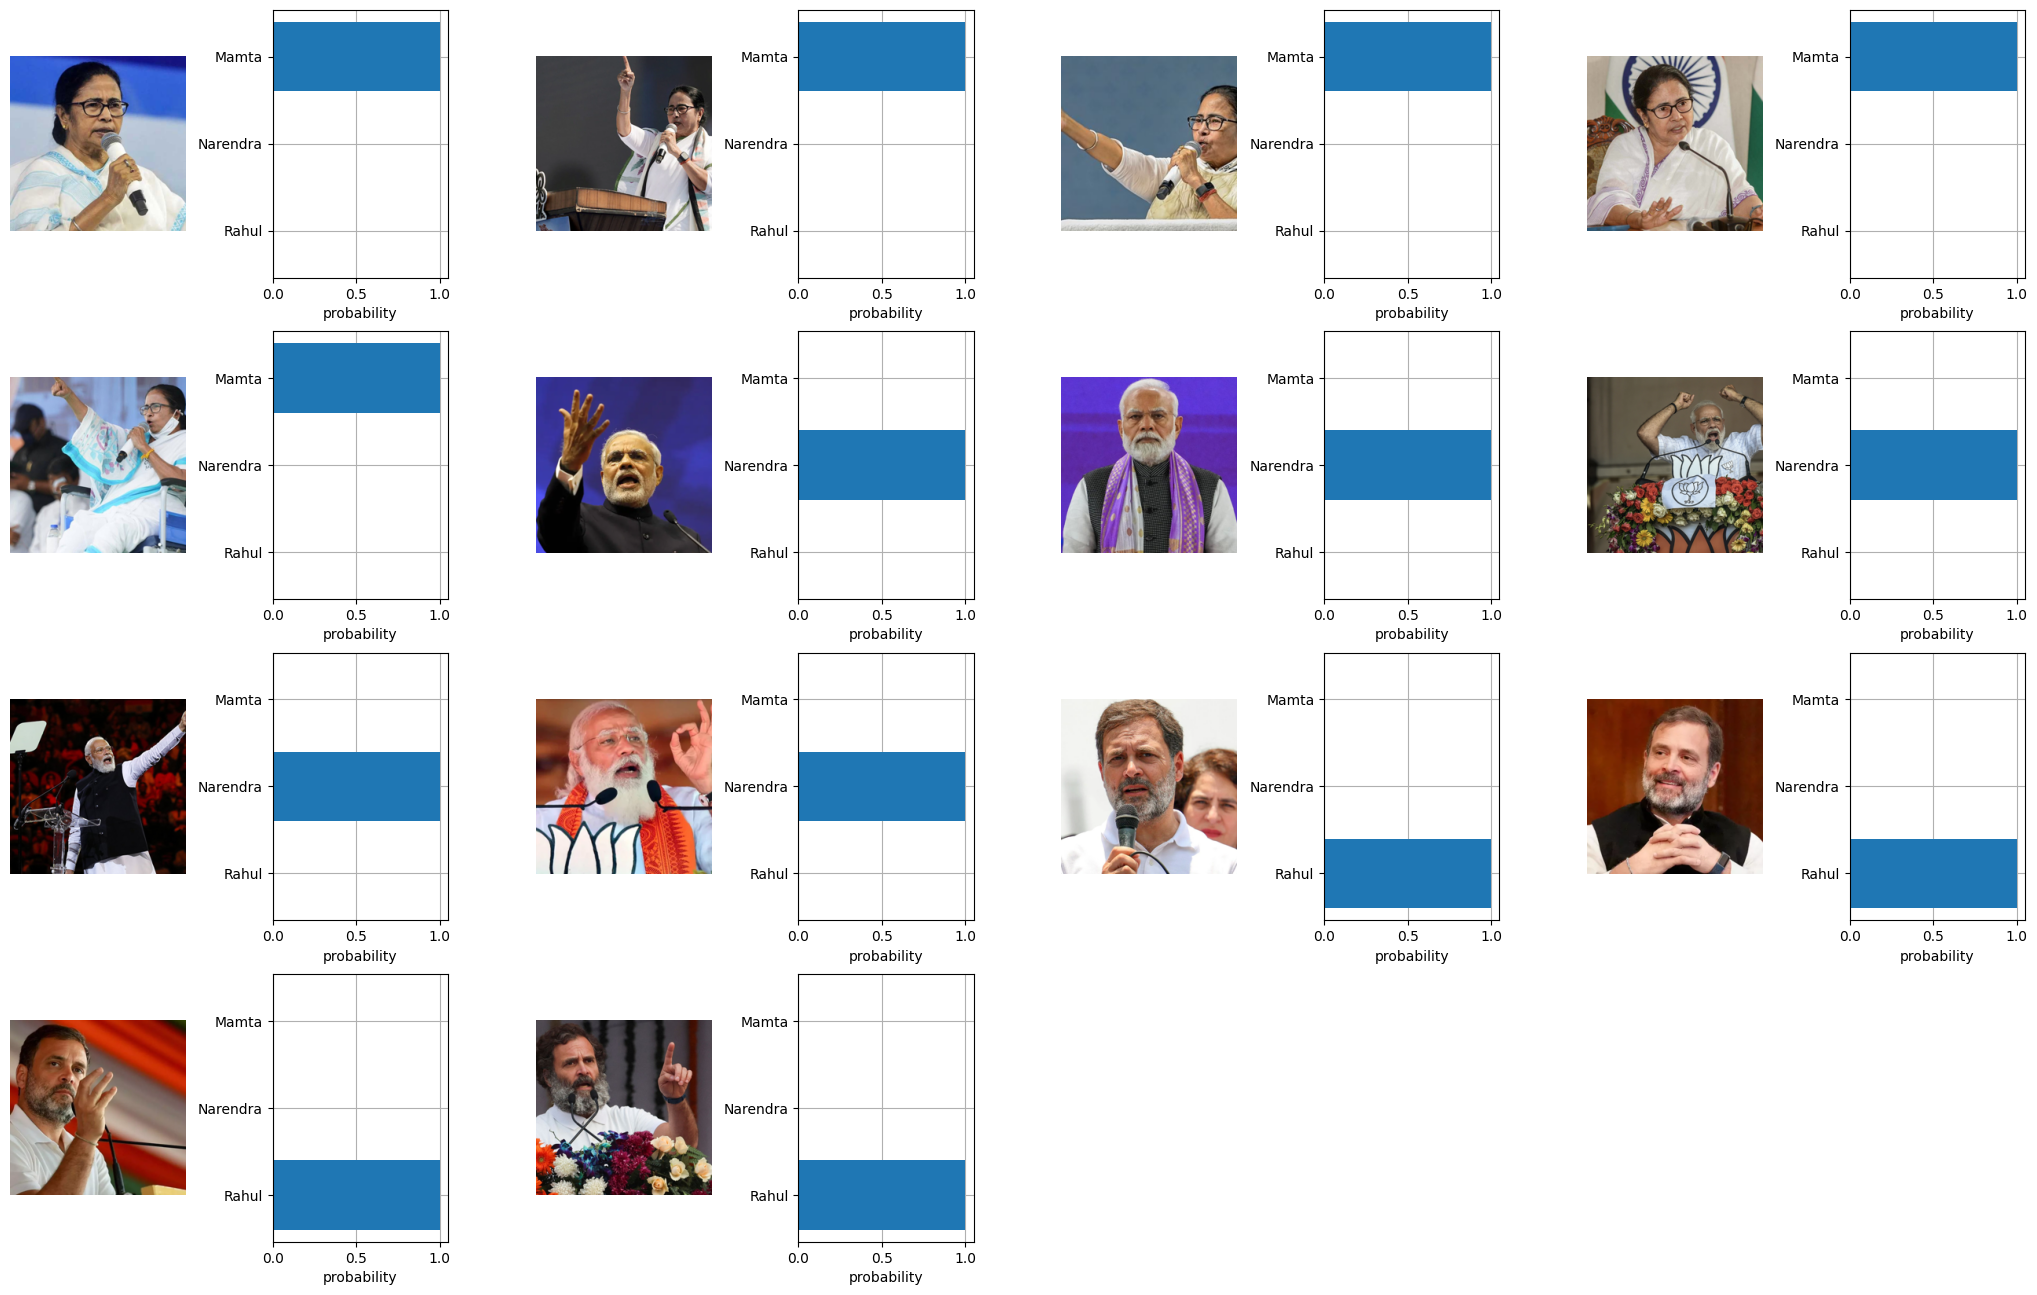

In [19]:
show_results(image_features, text_features, class_names)

# Experiments



## Male/female classification


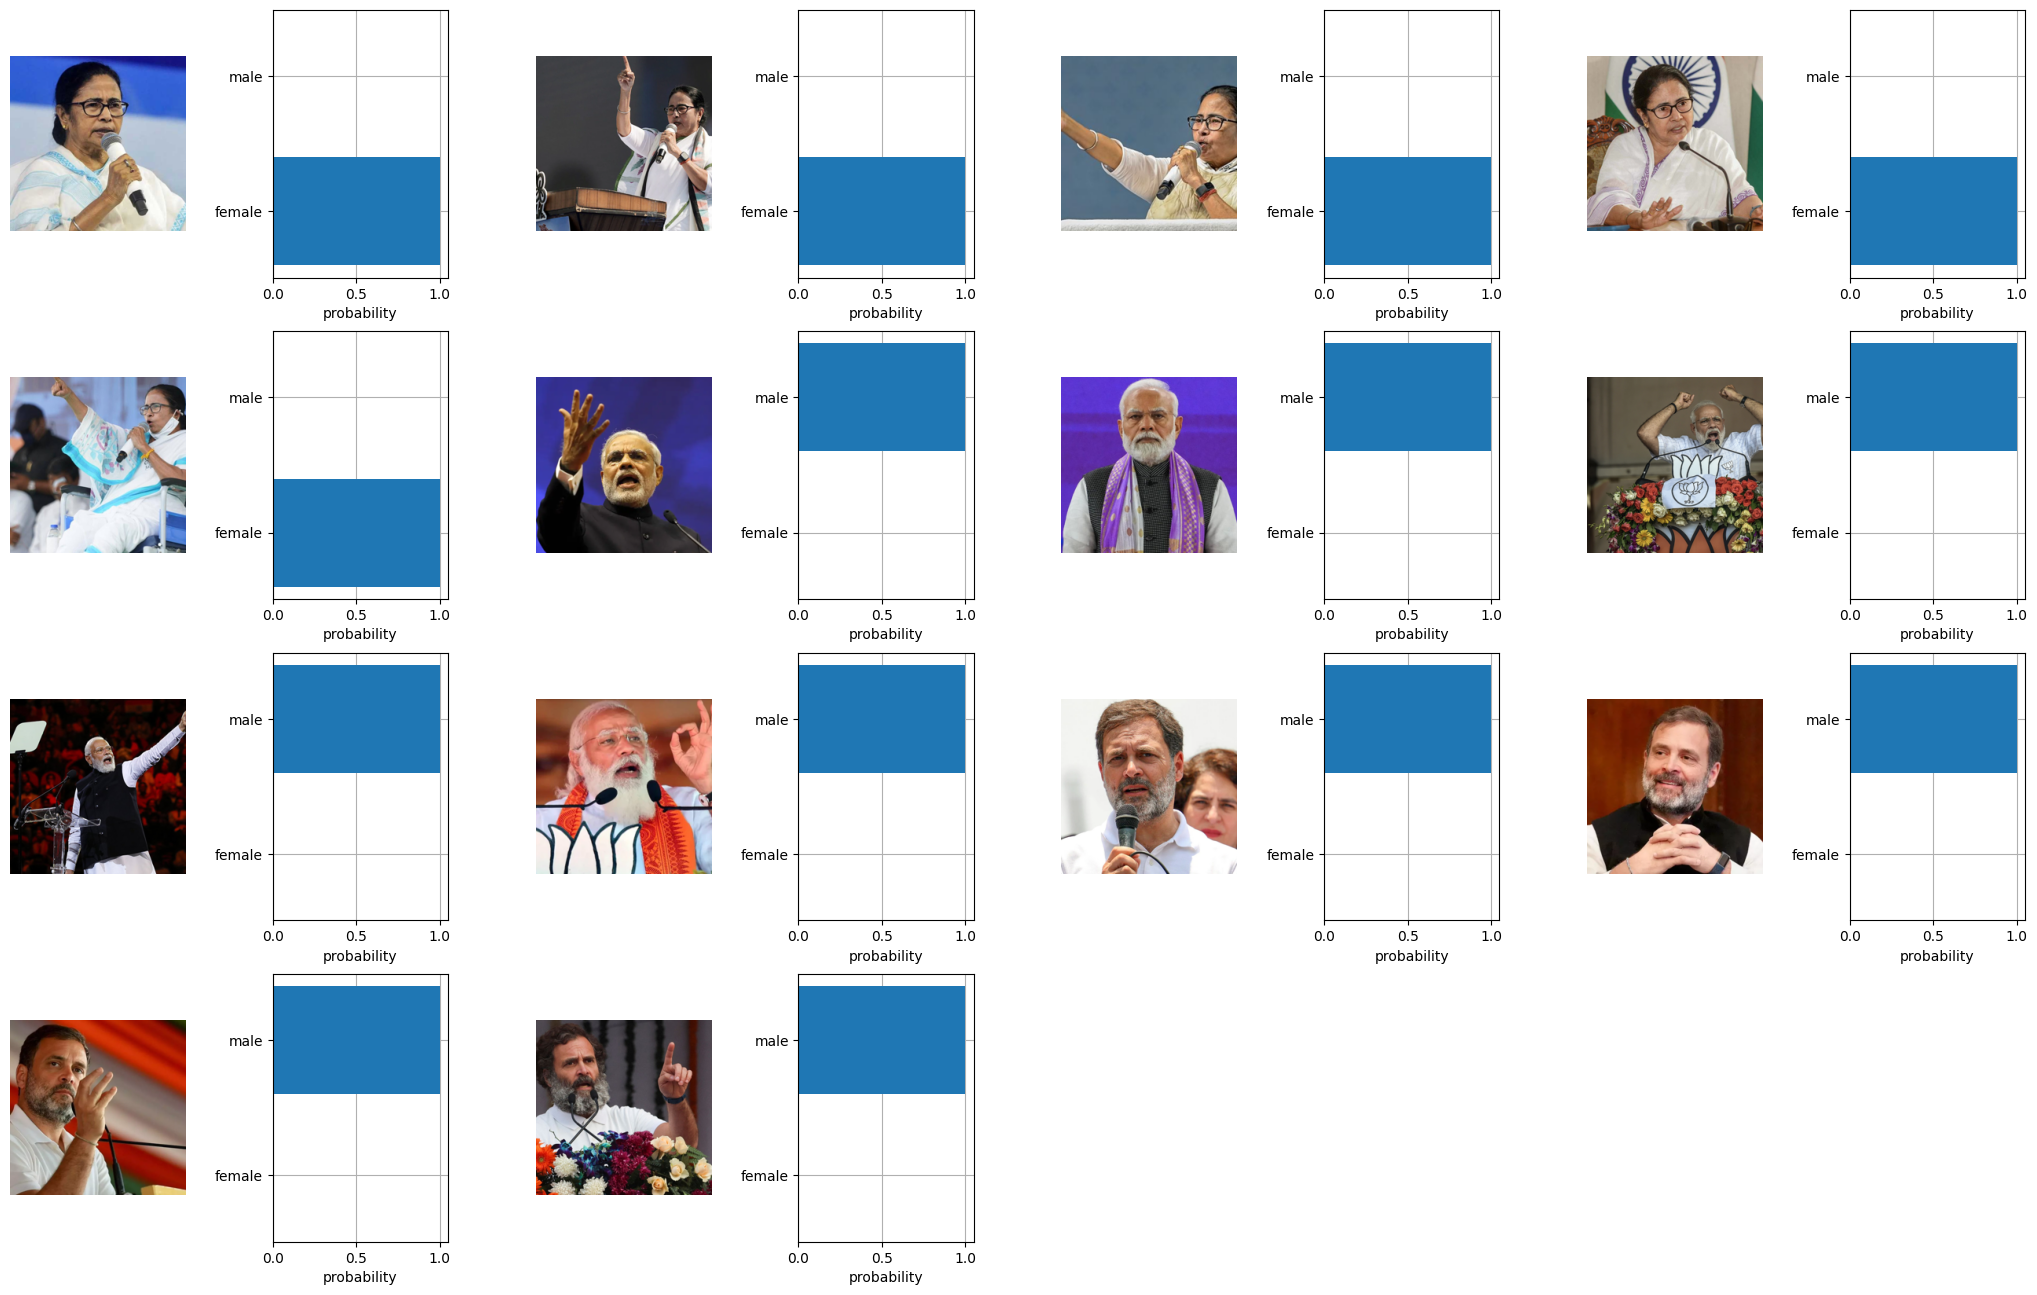

In [20]:
class_names = ['male', 'female']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Object detection/presence?

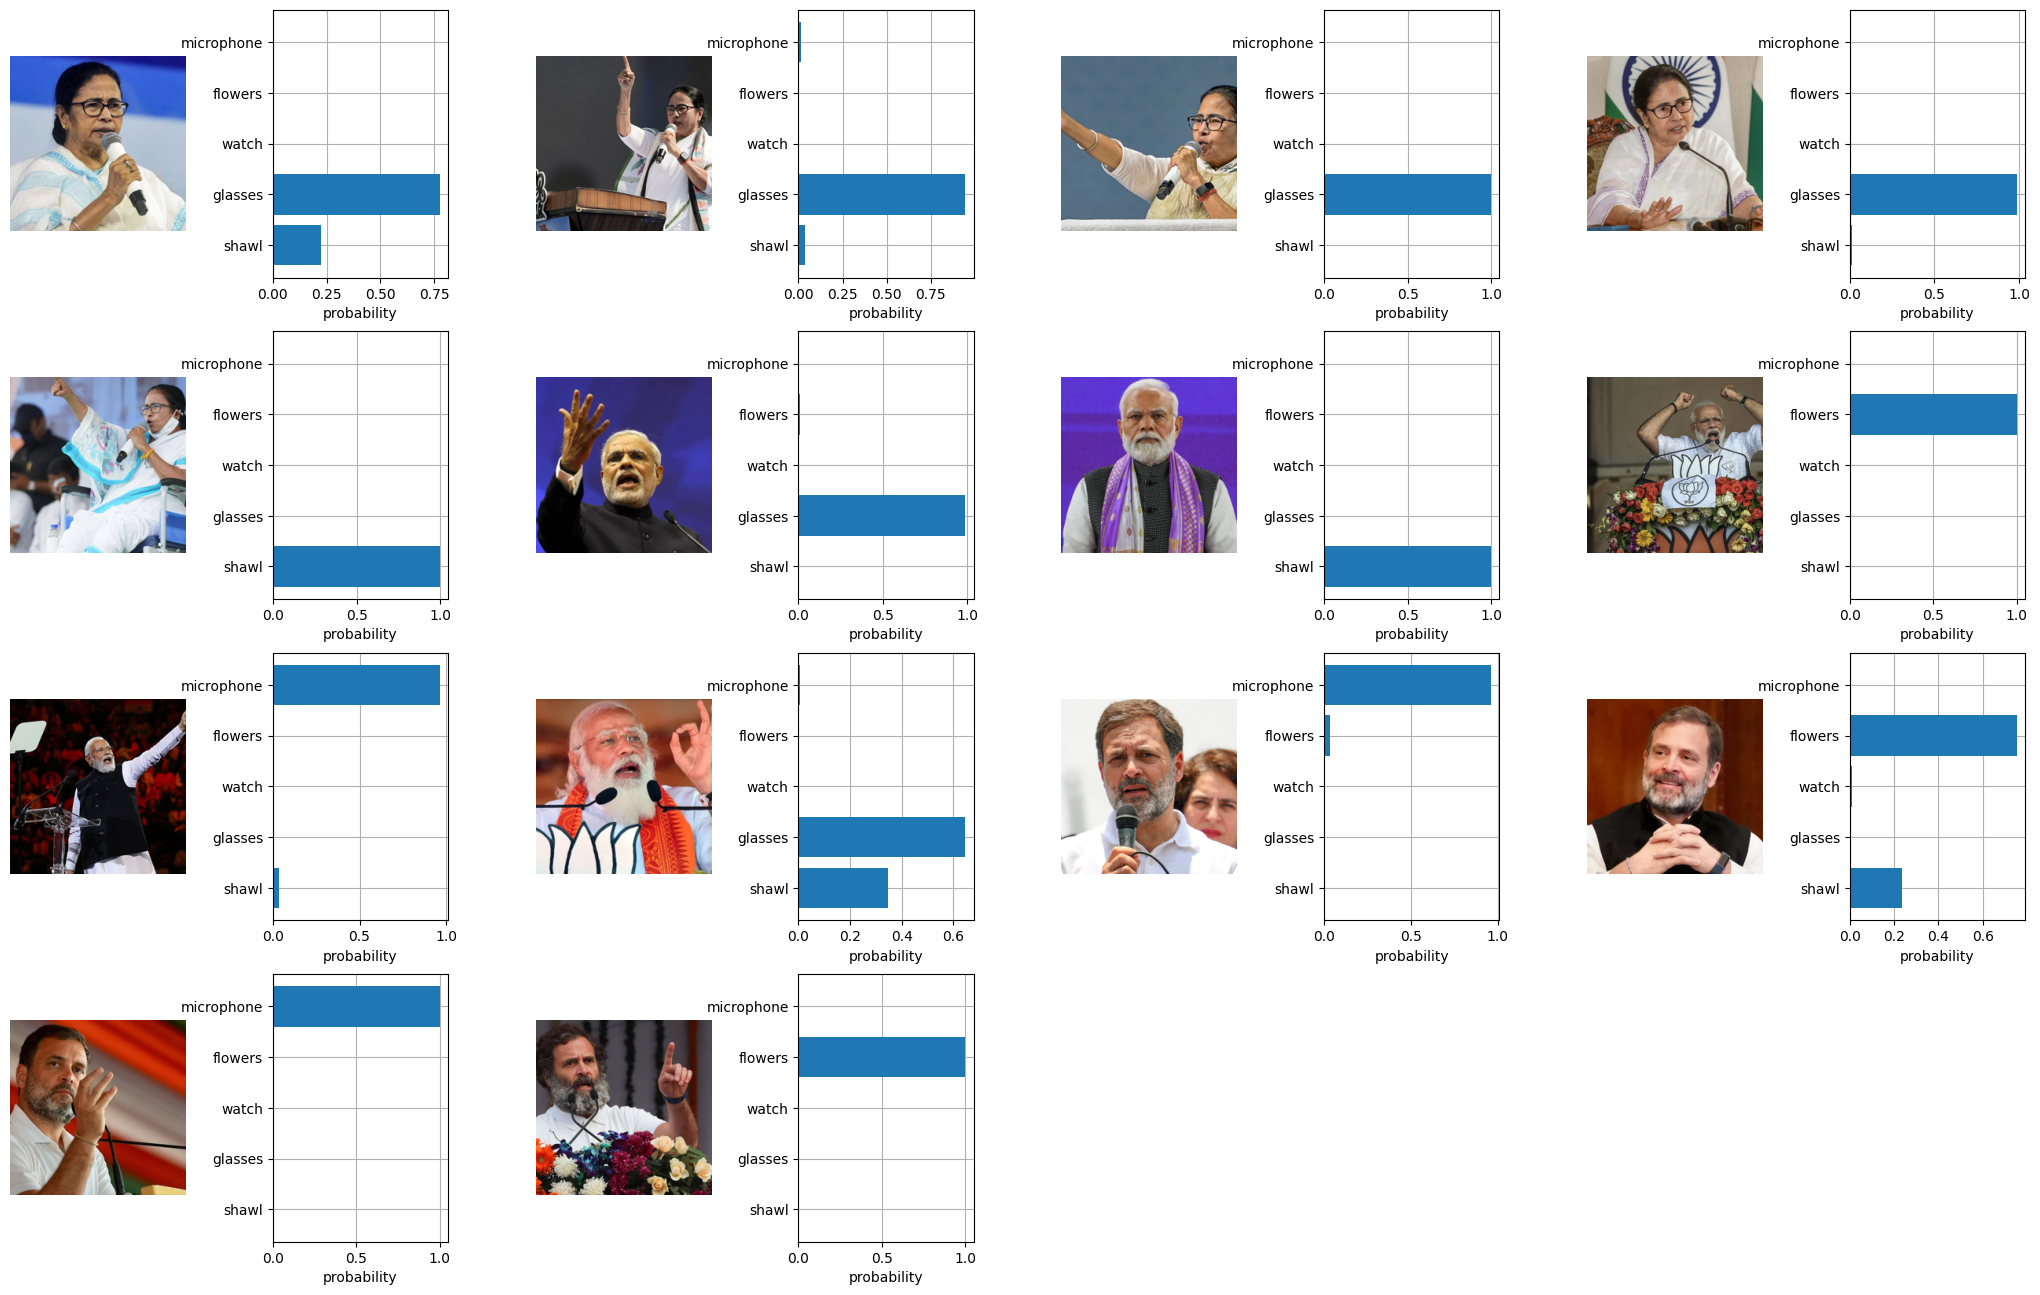

In [21]:
class_names = ['microphone', 'flowers', 'watch', 'glasses','shawl']
class_captions = [f"An image showing a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Objects counting by words and digits

Since we have at least one image with two microphones, I wanted to see if CLIP can detect it. We test both variants: `two` and `2`.

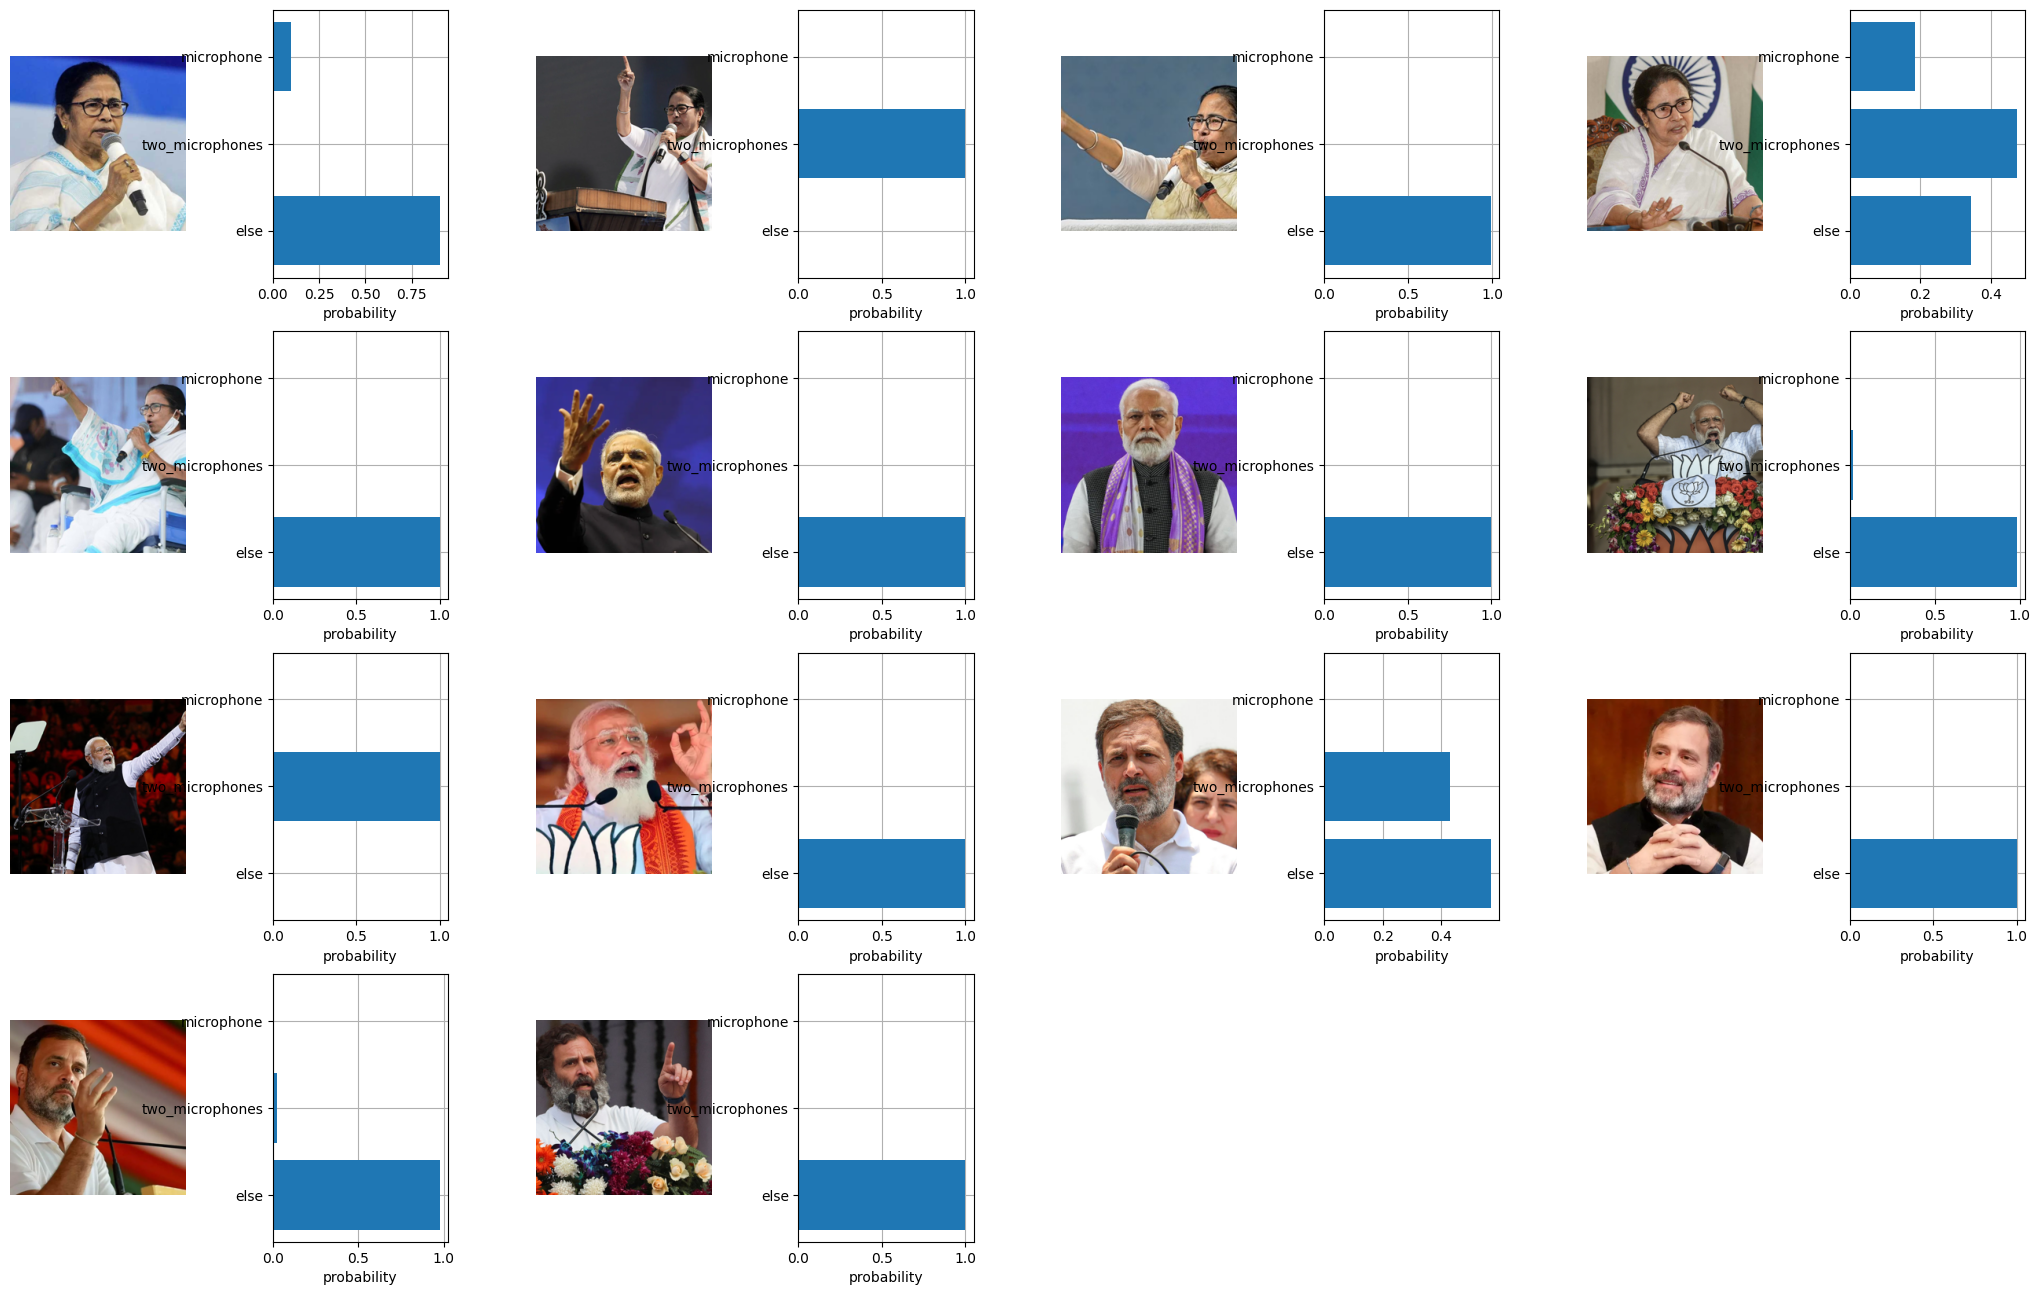

In [22]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing two microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

We can also see that words description is better than digits-based.

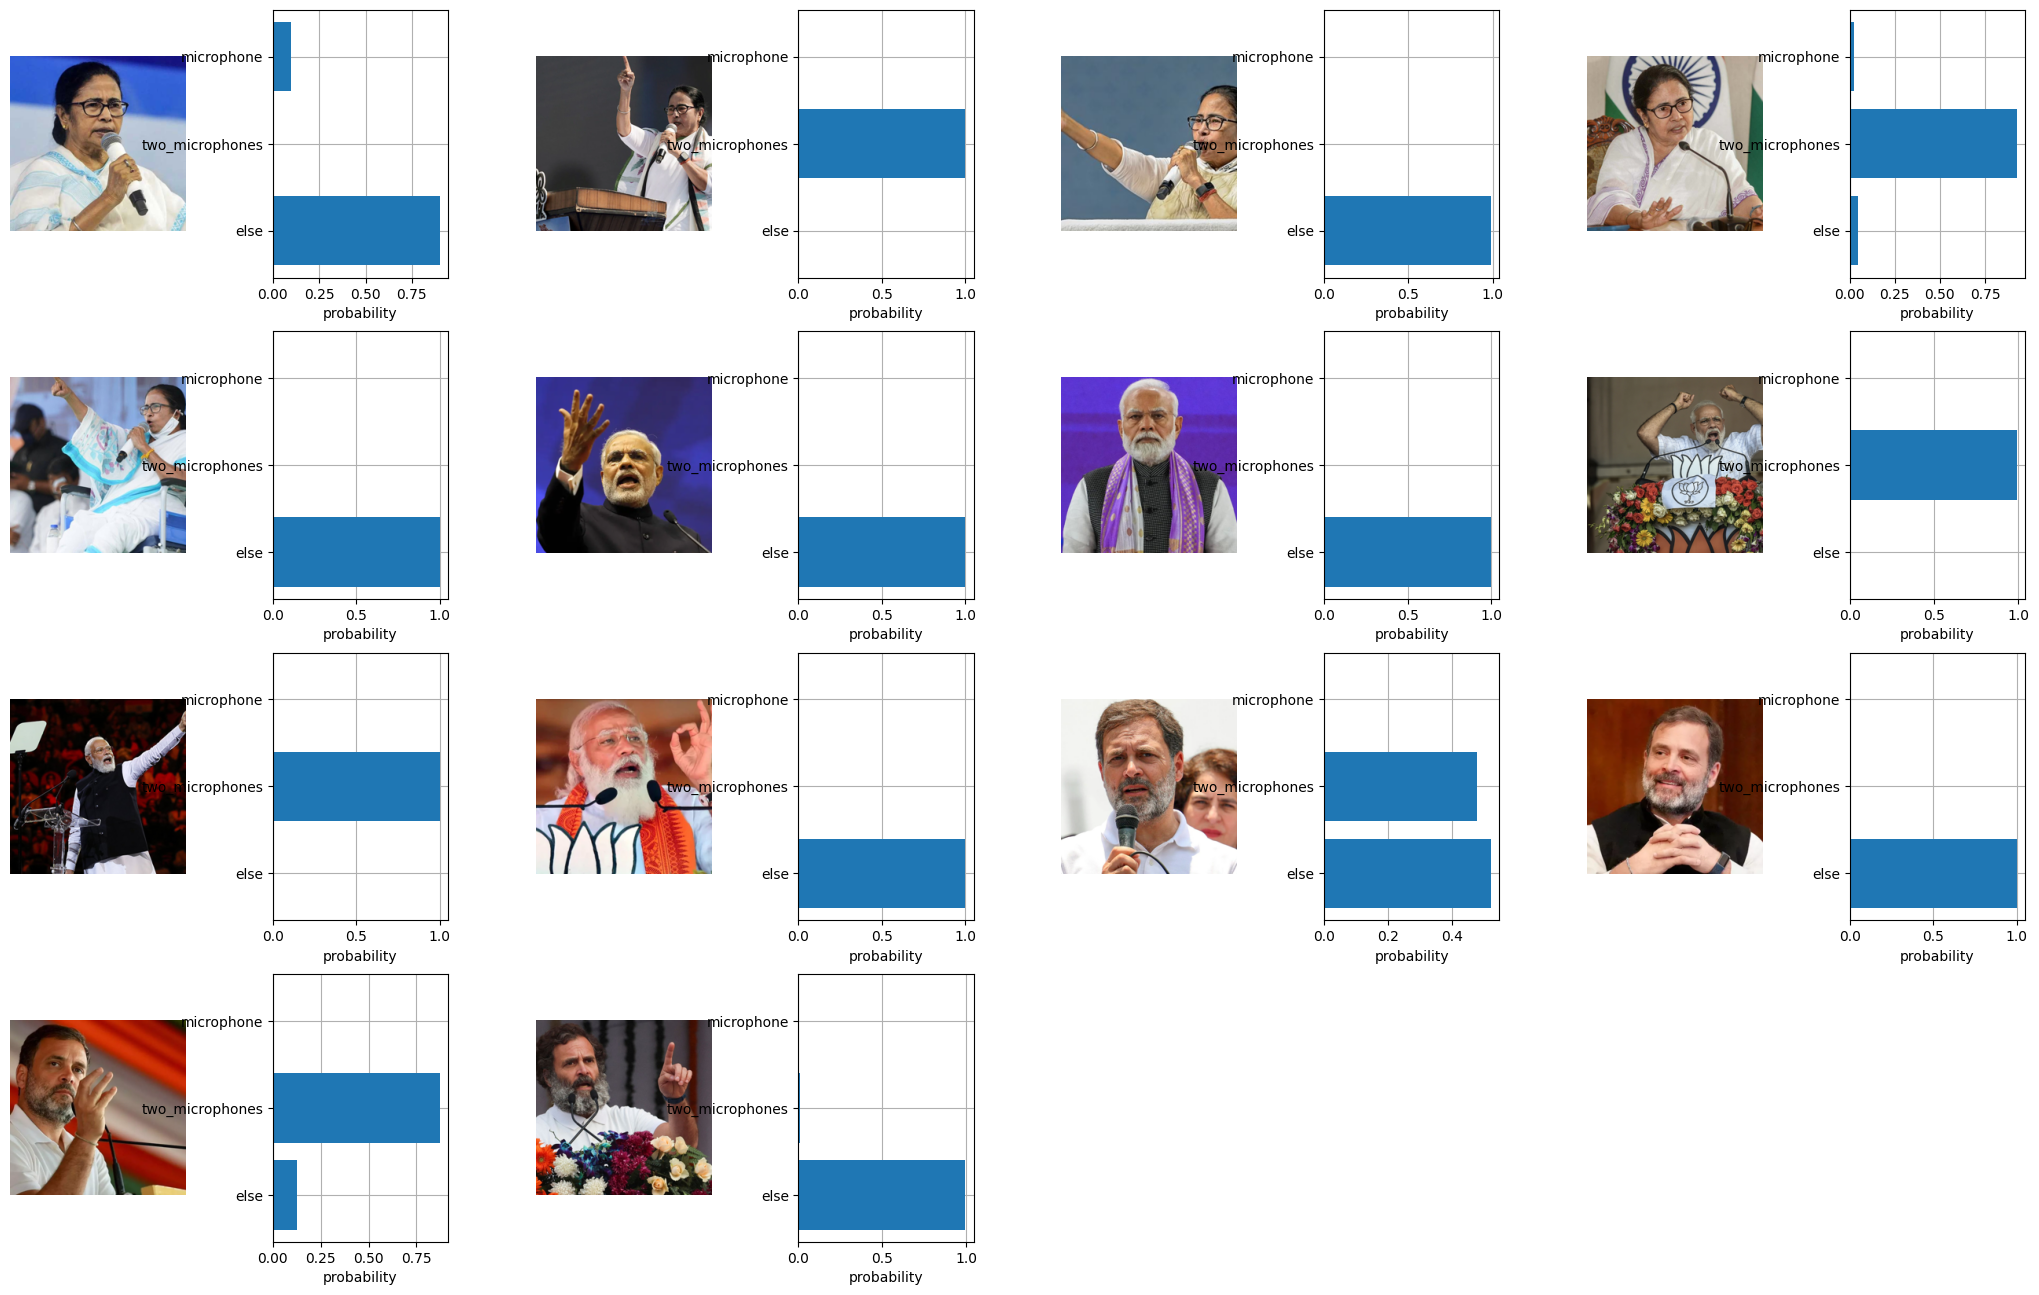

In [23]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing 2 microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Add conditions to class descriptions

The idea here is that we add a condition in text description. For this small dataset this is very fragile.

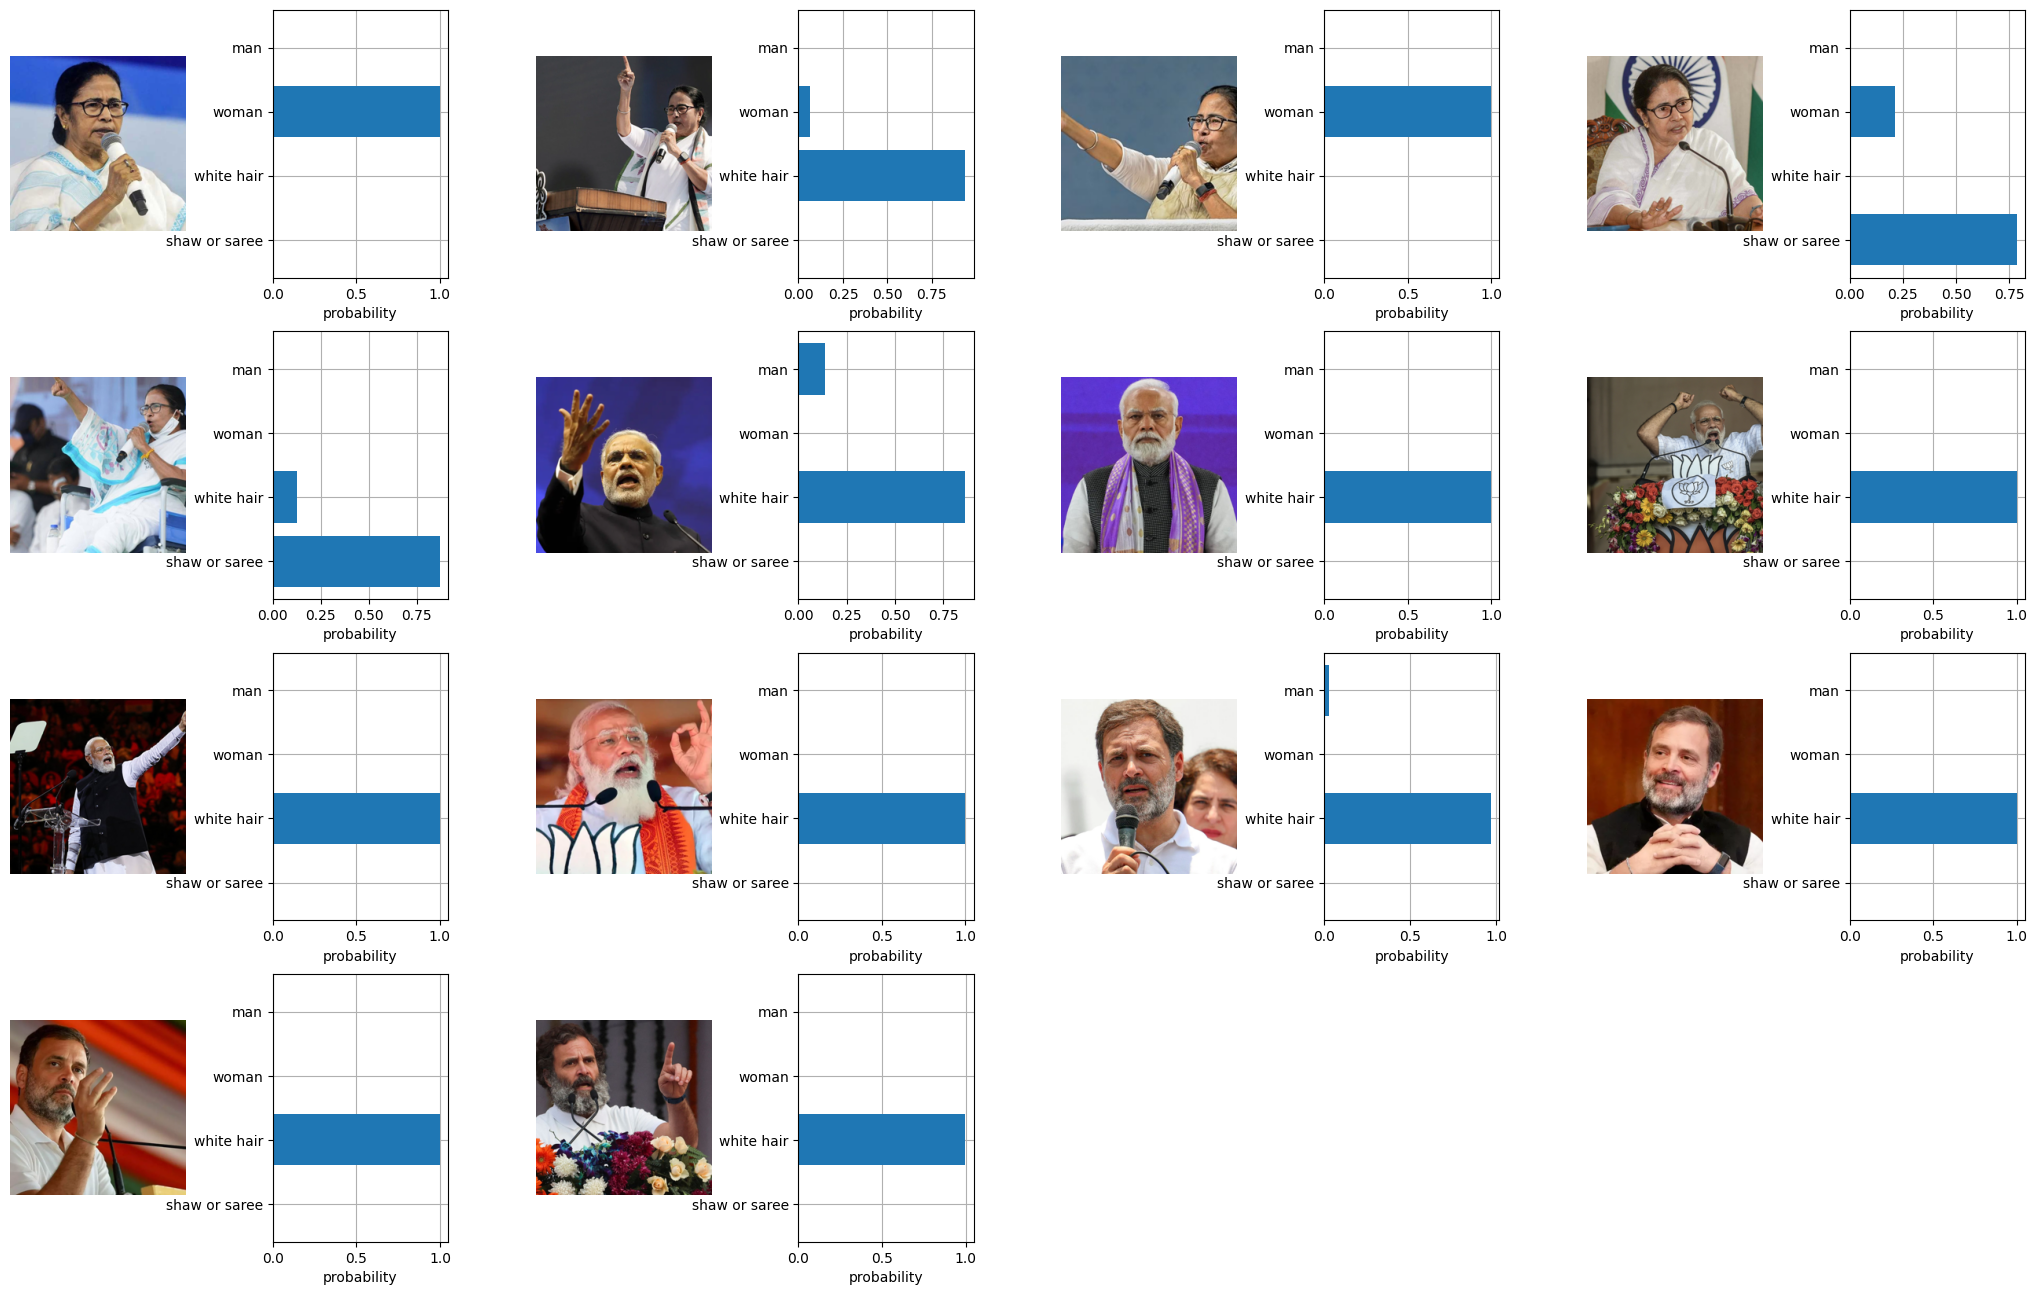

In [24]:
class_names = ["man", "woman", "white hair", "shawl or saree"]
class_captions = ["A photo of a man", "A photo of a woman", "A photo of a man with white hai", "A photo of a woman in shawl or saree"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)